In [ ]:
import os
import pandas as pd
from sklearn.utils import shuffle
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split
import numpy as np
from torchsummary import summary

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d oluwaseunad/concrete-and-pavement-crack-images

 99% 317M/319M [00:11<00:00, 40.9MB/s]
100% 319M/319M [00:11<00:00, 30.0MB/s]


In [ ]:
!unzip -q concrete-and-pavement-crack-images.zip

In [ ]:
!ls

concrete-and-pavement-crack-images.zip	kaggle.json  Negative  Positive  sample_data


In [ ]:
# Load data paths and labels
path_Negative = '/content/Negative'
path_Positive = '/content/Positive'
positive_images = [os.path.join(path_Positive, img) for img in os.listdir(path_Positive)]
negative_images = [os.path.join(path_Negative, img) for img in os.listdir(path_Negative)]
all_images = positive_images + negative_images
labels = [1] * len(positive_images) + [0] * len(negative_images)  # Convert to integers
df = pd.DataFrame(list(zip(all_images, labels)), columns=['Filepath', 'Label'])

In [ ]:
df = shuffle(df, random_state=42)

In [ ]:
df.head(5)

,Filepath,Label
2308,/content/Positive/14606.jpg,1
22404,/content/Negative/14409.jpg,0
23397,/content/Negative/05699.jpg,0
25058,/content/Negative/03792.jpg,0
2664,/content/Positive/02665.jpg,1


In [ ]:
df["Label"].value_counts()

1    15000
0    15000
Name: Label, dtype: int64

In [ ]:
# Data Preprocessing
class CustomDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_name = self.df.iloc[idx, 0]
        image = io.imread(img_name)
        label = int(self.df.iloc[idx, 1])
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
# import cv2
# import os
# import numpy as np

# def calculate_mean_std(folder_path):
#     # Initialize lists to store mean and standard deviation
#     means = []
#     stds = []

#     # Iterate through all files in the folder
#     for filename in os.listdir(folder_path):
#         if filename.endswith('.jpg') or filename.endswith('.png') or filename.endswith('.jpeg'):
#             # Read the image
#             image = cv2.imread(os.path.join(folder_path, filename))

#             # Convert image to float32
#             image = image.astype(np.float32)

#             # Calculate mean and standard deviation
#             mean, std = cv2.meanStdDev(image)

#             # Append to lists
#             means.append(mean)
#             stds.append(std)

#     # Calculate overall mean and standard deviation
#     overall_mean = np.mean(means, axis=0)
#     overall_std = np.mean(stds, axis=0)

#     return overall_mean, overall_std

# # Folder paths
# positive_folder = '/content/Positive'
# negative_folder = '/content/Negative'

# # Calculate mean and standard deviation for positive images
# positive_mean, positive_std = calculate_mean_std(positive_folder)
# print("Positive Mean:", positive_mean)
# print("Positive Standard Deviation:", positive_std)

# # Calculate mean and standard deviation for negative images
# negative_mean, negative_std = calculate_mean_std(negative_folder)
# print("\nNegative Mean:", negative_mean)
# print("Negative Standard Deviation:", negative_std)

# #Calculating net mean
# print("\nNet Mean:",(positive_mean + negative_mean)/2)
# print("\nNet Standard Deviation:", (negative_std + positive_std)/2)



In [ ]:
# mean = [107.79140917/255, 130.11784592/255, 152.01397823/255]
# std = [14.87674105/255, 15.43544798/255, 15.69436533/255]

In [ ]:
#Normalisation is skipped

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
])

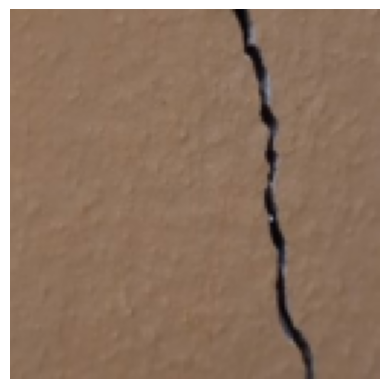

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Define the transformation
transform_ = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std),
])

# Function to load and transform the image
def load_and_transform_image(image_path, transform):
    # Load the image
    img = Image.open(image_path)
    # Apply the transformation
    transformed_img = transform(img)
    return transformed_img

image_path = "/content/Positive/00750.jpg"

# Load and transform the image
transformed_image = load_and_transform_image(image_path, transform_)

# Convert tensor to numpy array and transpose the dimensions
# to (height, width, channels) for visualization
image_np = transformed_image.numpy().transpose((1, 2, 0))

# Visualize the transformed image
plt.imshow(image_np)
plt.axis('off')
plt.show()


In [ ]:
# Split data into train and test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

In [ ]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
from torchvision.models import ResNet50_Weights

In [ ]:
# Define the model
class Rasnet50(nn.Module):
    def __init__(self):
        super(Rasnet50, self).__init__()
        self.resnet = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # Freeze ResNet parameters
        for param in self.resnet.parameters():
            param.requires_grad = False

        self.resnet.fc = nn.Sequential(
                  nn.Linear(2048, 512),
                  nn.ReLU(),
                  nn.BatchNorm1d(512),  # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(512, 512),
                  nn.ReLU(),
                  nn.BatchNorm1d(512),  # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(512, 256),
                  nn.ReLU(),
                  nn.BatchNorm1d(256),  # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(256, 256),
                  nn.ReLU(),
                  nn.BatchNorm1d(256),   # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(256, 128),
                  nn.ReLU(),
                  nn.BatchNorm1d(128),   # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(128, 128),
                  nn.ReLU(),
                  nn.BatchNorm1d(128),   # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(128, 64),
                  nn.ReLU(),
                  nn.BatchNorm1d(64),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(64, 64),
                  nn.BatchNorm1d(64),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(64, 32),
                  nn.BatchNorm1d(32),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(32, 32),
                  nn.BatchNorm1d(32),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(32, 16),
                  nn.BatchNorm1d(16),    # Batch Normalization
                  nn.Dropout(0.5),      # Dropout
                  nn.Linear(16, 2),
                  nn.Softmax(dim=1)  # Apply softmax layer
              )
    def forward(self, x):
        x = self.resnet(x)
        return x

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
rasnet50 = Rasnet50()

In [ ]:
  rasnet50.to(device)

Rasnet50(
  (resnet): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          

In [ ]:
summary(rasnet50,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]           4,096
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
           Conv2d-11          [-1, 256, 32, 32]          16,384
      BatchNorm2d-12          [-1, 256, 32, 32]             512
           Conv2d-13          [-1, 256, 32, 32]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rasnet50.resnet.fc.parameters(), lr=0.001)

In [ ]:
correct = 0
total = 0
no_of_epoch = 10
for epoch in range(no_of_epoch):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = rasnet50(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 10 == 9:  # print every 10 mini-batches
            print(f"Epoch [{epoch + 1}/{no_of_epoch}], Batch [{i + 1}/{len(trainloader)}], Loss: {running_loss / 10:.3f} (epoch loss)")
            running_loss = 0.0

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Accuracy of the network on the {total} train images: %d %%' % (
        100 * correct / total))
    correct = 0
    total = 0

print('Finished Training')




Epoch [1/10], Batch [10/375], Loss: 0.698 (epoch loss)
Epoch [1/10], Batch [20/375], Loss: 0.696 (epoch loss)
Epoch [1/10], Batch [30/375], Loss: 0.703 (epoch loss)
Epoch [1/10], Batch [40/375], Loss: 0.702 (epoch loss)
Epoch [1/10], Batch [50/375], Loss: 0.699 (epoch loss)
Epoch [1/10], Batch [60/375], Loss: 0.702 (epoch loss)
Epoch [1/10], Batch [70/375], Loss: 0.699 (epoch loss)
Epoch [1/10], Batch [80/375], Loss: 0.707 (epoch loss)
Epoch [1/10], Batch [90/375], Loss: 0.699 (epoch loss)
Epoch [1/10], Batch [100/375], Loss: 0.689 (epoch loss)
Epoch [1/10], Batch [110/375], Loss: 0.693 (epoch loss)
Epoch [1/10], Batch [120/375], Loss: 0.670 (epoch loss)
Epoch [1/10], Batch [130/375], Loss: 0.653 (epoch loss)
Epoch [1/10], Batch [140/375], Loss: 0.629 (epoch loss)
Epoch [1/10], Batch [150/375], Loss: 0.611 (epoch loss)
Epoch [1/10], Batch [160/375], Loss: 0.577 (epoch loss)
Epoch [1/10], Batch [170/375], Loss: 0.551 (epoch loss)
Epoch [1/10], Batch [180/375], Loss: 0.523 (epoch loss)
E

In [ ]:
import torch
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm

# Assuming testloader is your DataLoader for the test dataset

# Initialize variables to keep track of metrics
predictions = []
true_labels = []

# Switch model to evaluation mode
rasnet50.eval()

with torch.no_grad():  # No need to compute gradients during evaluation
    for data in tqdm(testloader, desc="Testing"):  # Loop over the test dataset
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        outputs = rasnet50(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Store predictions and true labels for metric calculation
        output = outputs.cpu().numpy()
        outputs = np.argmax(output,axis=1)
        predictions.extend(outputs)

        # predictions.extend()
        # print(predictions[0])
        true_labels.extend(labels.cpu().numpy())  #sorted

predictions = np.array(predictions)
true_labels = np.array(true_labels)

# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, predictions)

# Calculate F1 score
f1 = f1_score(true_labels, predictions)

# Calculate accuracy
accuracy = (predictions == true_labels).mean()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")


In [ ]:
# Save entire model
torch.save(rasnet50, 'rasnet50_pytorch.pth')

In [ ]:
# Load entire model
model = torch.load('rasnet50_pytorch.pth')

In [ ]:
import torch
from sklearn.metrics import roc_auc_score, f1_score
from tqdm import tqdm

# Assuming testloader is your DataLoader for the test dataset

# Initialize variables to keep track of metrics
predictions = []
true_labels = []

# Switch model to evaluation mode
model.eval()

with torch.no_grad():  # No need to compute gradients during evaluation
    for data in tqdm(testloader, desc="Testing"):  # Loop over the test dataset
        inputs, labels = data[0].to(device), data[1].to(device)

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Store predictions and true labels for metric calculation
        output = outputs.cpu().numpy()
        outputs = np.argmax(output,axis=1)
        predictions.extend(outputs)

        # predictions.extend()
        # print(predictions[0])
        true_labels.extend(labels.cpu().numpy())  #sorted


# Calculate ROC AUC score
roc_auc = roc_auc_score(true_labels, predictions)

# Calculate F1 score
f1 = f1_score(true_labels, predicted_labels)

# Calculate accuracy
accuracy = (predicted_labels == true_labels).mean()

print(f"ROC AUC: {roc_auc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy * 100:.2f}%")
